<a href="https://colab.research.google.com/github/ekumar0987/Machine-Learning/blob/main/Stock%20Closing%20Price%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Business Problem

Develop a predictive model to forecast the closing price of a stock on any given day, facilitating data-driven financial analysis for portfolio optimization, risk assessment, and strategy development in algorithmic trading systems. The goal is to leverage historical price and volume data to generate accurate, timely predictions that can support investment decisions and enhance market responsiveness.

### Data Extraction

##### Unzip and load the data

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
import traceback

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    traceback.print_exc()

Mounted at /content/drive


In [ ]:
import zipfile
import os
import pandas as pd

print("Current Working Directory: ", os.getcwd())
os.chdir('/content/drive/My Drive/Pinky Personal/Data Science/Data')
print("New Working Directory: ", os.getcwd())

zip_file_path = 'archive.zip'
extract_to_dir = '.'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

In [3]:
import os
print(os.listdir('/content/drive/My Drive/Pinky Personal/Data Science/Data'))

['archive.zip', 'ETFs', 'Stocks', 'Data']


##### Create a unified financial dataset
Read data from each stock/ETF file and merge it into a single dataset. Augment data with ticker and type information

In [4]:
import os
import pandas as pd

print(os.getcwd())
os.chdir('/content/drive/My Drive/Pinky Personal/Data Science/Data')

def load_data_from_directory(directory, data_type):
    all_data = []
    for filename in os.listdir(directory):
      if filename.endswith('.txt'):
          file_path = os.path.join(directory, filename)
          if os.stat(file_path).st_size == 0:  # Check if the file is empty
              print(f"Skipping empty file: {filename}")
              continue
          stock_data = pd.read_csv(file_path)
          ticker = filename.split('/')[-1].replace('.us.txt', '')
          stock_data['Ticker'] = ticker
          stock_data['Type'] = data_type  # Add type column (Stock or ETF)
          all_data.append(stock_data)

    return pd.concat(all_data, ignore_index=True)

stocks_data = load_data_from_directory('/content/drive/My Drive/Pinky Personal/Data Science/Data/Stocks', 'Stock')
etfs_data = load_data_from_directory('/content/drive/My Drive/Pinky Personal/Data Science/Data/ETFs', 'ETF')

# Combine the stocks and ETFs data into a single DataFrame
combined_data = pd.concat([stocks_data, etfs_data], ignore_index=True)


/content
Skipping empty file: stnl.us.txt
Skipping empty file: vist.us.txt
Skipping empty file: vmet.us.txt
Skipping empty file: wnfm.us.txt
Skipping empty file: wspt.us.txt
Skipping empty file: pxus.us.txt
Skipping empty file: rbio.us.txt
Skipping empty file: sail.us.txt
Skipping empty file: sbt.us.txt
Skipping empty file: scci.us.txt
Skipping empty file: scph.us.txt
Skipping empty file: send.us.txt
Skipping empty file: sfix.us.txt
Skipping empty file: srva.us.txt
Skipping empty file: molc.us.txt
Skipping empty file: otg.us.txt
Skipping empty file: pbio.us.txt
Skipping empty file: jt.us.txt
Skipping empty file: mapi.us.txt
Skipping empty file: fmax.us.txt
Skipping empty file: gnst.us.txt
Skipping empty file: hayu.us.txt
Skipping empty file: ehr.us.txt
Skipping empty file: amrh.us.txt
Skipping empty file: amrhw.us.txt
Skipping empty file: asns.us.txt
Skipping empty file: bbrx.us.txt
Skipping empty file: bolt.us.txt
Skipping empty file: boxl.us.txt
Skipping empty file: bxg.us.txt
Skippi

##### Exploratory Data Analysis

In [5]:
import pandas as pd

print(combined_data.head())

print(combined_data.describe())

print(combined_data.info())

         Date  Open  High   Low  Close  Volume  OpenInt Ticker   Type
0  2005-02-25  6.34  6.44  6.34   6.41    3200        0    ssy  Stock
1  2005-02-28  6.43  6.58  6.43   6.58    1500        0    ssy  Stock
2  2005-03-01  6.68  6.98  6.68   6.89    7200        0    ssy  Stock
3  2005-03-02  6.90  6.92  6.90   6.92    1500        0    ssy  Stock
4  2005-03-03  6.90  6.97  6.85   6.91    3000        0    ssy  Stock
               Open          High           Low         Close        Volume  \
count  1.734963e+07  1.734963e+07  1.734963e+07  1.734963e+07  1.734963e+07   
mean   2.640558e+04  2.713204e+04  2.551322e+04  2.628423e+04  1.584399e+06   
std    3.893492e+06  4.005609e+06  3.749401e+06  3.873196e+06  8.425127e+06   
min    0.000000e+00  4.000000e-03 -1.000000e+00  3.700000e-03  0.000000e+00   
25%    8.876900e+00  9.006400e+00  8.730400e+00  8.875200e+00  2.573900e+04   
50%    1.837400e+01  1.862000e+01  1.811000e+01  1.837300e+01  1.573460e+05   
75%    3.366100e+01  3.4063

##### Data Preprocessing

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore', message='is_sparse is deprecated and will be removed in a future version.*')

sampled_data = combined_data.sample(frac=0.1, random_state=42)

sampled_data['Datetime'] = pd.to_datetime(sampled_data['Date'])
sampled_data.sort_values(by='Datetime', inplace=True)
sampled_data['Year'] = sampled_data['Datetime'].dt.year
sampled_data['Month'] = sampled_data['Datetime'].dt.month
sampled_data['Day'] = sampled_data['Datetime'].dt.day

# Encode 'Type' using one-hot encoding
sampled_data = pd.get_dummies(sampled_data, columns=['Type'], dtype=int)

# Initialize LabelEncoder
label_encoder = LabelEncoder()
sampled_data['TickerEncoded'] = label_encoder.fit_transform(sampled_data['Ticker'])

# Now drop the original 'Ticker' column
sampled_data.drop('Ticker', axis=1, inplace=True)

# Define y and X from sampled_data
y = sampled_data['Close']
X = sampled_data.drop(['Close', 'Date', 'Datetime', 'OpenInt'], axis=1)

# Define columns to scale (excluding 'Year', 'Month', 'Day', 'TickerEncoded')
columns_to_scale = ['Open', 'High', 'Low', 'Volume']

# Initialize StandardScaler for features and target
scaler_features = StandardScaler()
scaler_target = StandardScaler()

# Prepare lists to store train and test data
train_dfs = []
test_dfs = []

# Define the maximum number of splits for TimeSeriesSplit
max_splits = 5

# Initialize the TimeSeriesSplit with a dynamic split number
tscv = TimeSeriesSplit(n_splits=max_splits)

# Group by 'TickerEncoded' and perform time series split
for ticker, group_data in X.groupby('TickerEncoded'):
    y_group = y[group_data.index].reset_index(drop=True)
    group_data = group_data.reset_index(drop=True)

    # Adjusting n_splits to ensure at least 2 splits if the group size allows
    if len(group_data) > 2:  # Check if group size allows for at least one split
        n_splits = min(max_splits, len(group_data) - 1)
        tscv = TimeSeriesSplit(n_splits=n_splits)

        for train_index, test_index in tscv.split(group_data):
            # Split into train and test sets
            X_train_grp, X_test_grp = group_data.iloc[train_index], group_data.iloc[test_index]
            y_train_grp, y_test_grp = y_group.iloc[train_index], y_group.iloc[test_index]

            # Scale features
            X_train_grp_scaled = scaler_features.fit_transform(X_train_grp[columns_to_scale])
            X_test_grp_scaled = scaler_features.transform(X_test_grp[columns_to_scale])

            # Scale target
            y_train_grp_scaled = scaler_target.fit_transform(y_train_grp.values.reshape(-1, 1)).flatten()
            y_test_grp_scaled = scaler_target.transform(y_test_grp.values.reshape(-1, 1)).flatten()

            X_train_grp = pd.concat([pd.DataFrame(X_train_grp_scaled, columns=columns_to_scale),
                                  X_train_grp.drop(columns=columns_to_scale).reset_index(drop=True)], axis=1)
            X_test_grp = pd.concat([pd.DataFrame(X_test_grp_scaled, columns=columns_to_scale),
                                 X_test_grp.drop(columns=columns_to_scale).reset_index(drop=True)], axis=1)

            # Append to the lists
            train_dfs.append((X_train_grp, y_train_grp_scaled))
            test_dfs.append((X_test_grp, y_test_grp_scaled))

    else:
        # Handle groups with 2 or fewer samples, perhaps by adding them entirely to training or testing
        pass

# Concatenate all training and testing groups
X_train, y_train = zip(*train_dfs)
X_train = pd.concat(X_train, ignore_index=True)
y_train = np.concatenate(y_train, axis=0)

X_test, y_test = zip(*test_dfs)
X_test = pd.concat(X_test, ignore_index=True)
y_test = np.concatenate(y_test, axis=0)

In [7]:
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define a parameter grid to search
param_dist = {
    'n_estimators': randint(50, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
}

# Initialize the XGBRegressor
xgb = XGBRegressor(random_state=42)

# Initialize the RandomizedSearchCV object
xgb_random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=100,
    scoring='r2',
    cv=3,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the data
xgb_random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding R2
best_score = xgb_random_search.best_score_
best_params = xgb_random_search.best_params_
print(f"Best R2 from Randomized Search: {best_score}")
print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best R2 from Randomized Search: 0.995241738859764
Best Parameters: {'colsample_bytree': 0.9977829850443283, 'gamma': 0.08796262633867269, 'learning_rate': 0.013615072723104174, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 865, 'subsample': 0.8985965620472096}


In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

# Create scorers dictionary
scorers = {
    'r2': make_scorer(r2_score),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}

# Pass the scorers dictionary to the scoring parameter
random_search = RandomizedSearchCV(estimator=xgb,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   scoring=scorers,
                                   refit='r2',  # Metric to refit the model on
                                   cv=3,
                                   verbose=3,
                                   random_state=42,
                                   n_jobs=-1,
                                   return_train_score=True)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# After fitting, the scores are stored in the cv_results_ attribute
cv_results = random_search.cv_results_

# Access the mean test score for each metric
mean_test_r2 = cv_results['mean_test_r2']
mean_test_neg_mse = cv_results['mean_test_neg_mean_squared_error']

Fitting 3 folds for each of 100 candidates, totalling 300 fits


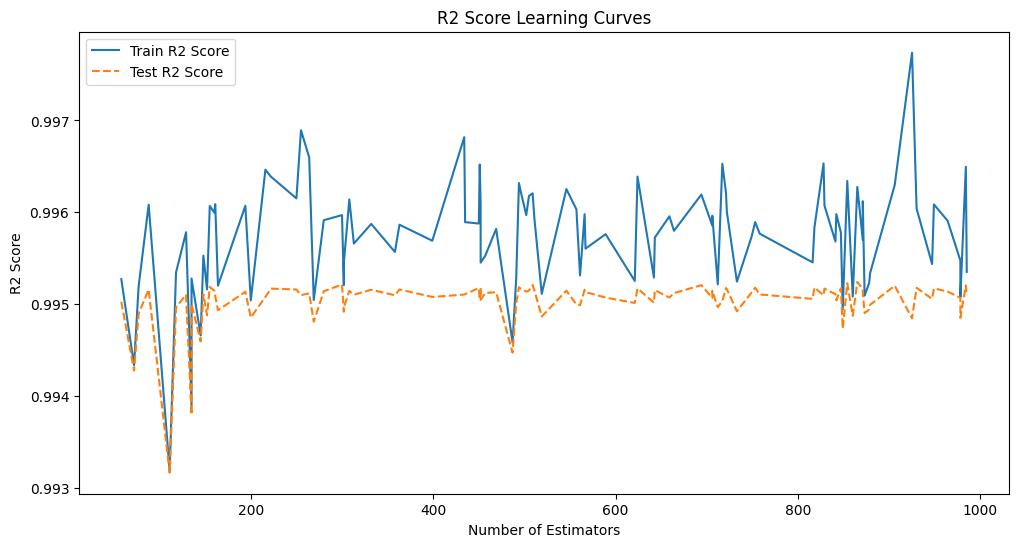

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming xgb_random_search.cv_results_ is the correct source for cv_results
cv_results = random_search.cv_results_

# Extract the mean training and test scores for each metric
mean_train_r2 = cv_results['mean_train_r2']
mean_test_r2 = cv_results['mean_test_r2']

# Assume we are only plotting for R2 scores as we don't usually plot negative MSE
# Extract the number of estimators for each iteration of the RandomizedSearchCV
# Note: This assumes 'n_estimators' was a parameter being tuned.
n_estimators = [params['n_estimators'] for params in cv_results['params']]

# Sort the scores by the number of estimators for plotting
sorted_indices = np.argsort(n_estimators)
n_estimators_sorted = np.array(n_estimators)[sorted_indices]
mean_train_r2_sorted = np.array(mean_train_r2)[sorted_indices]
mean_test_r2_sorted = np.array(mean_test_r2)[sorted_indices]

# Plot the learning curves for R2 Score
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_sorted, mean_train_r2_sorted, label='Train R2 Score')
plt.plot(n_estimators_sorted, mean_test_r2_sorted, label='Test R2 Score', linestyle='--')
plt.xlabel('Number of Estimators')
plt.ylabel('R2 Score')
plt.title('R2 Score Learning Curves')
plt.legend()
plt.show()

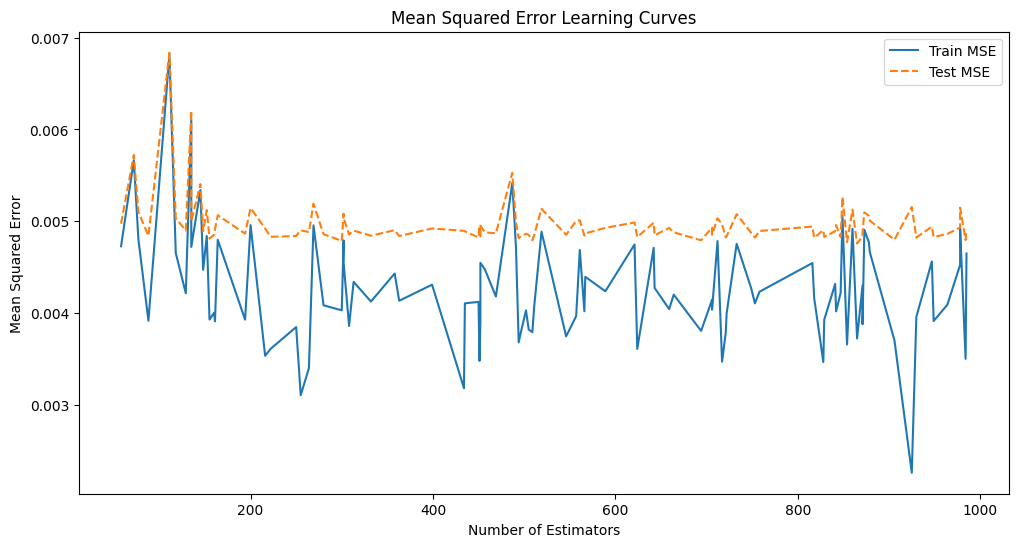

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming random_search.cv_results_ contains the correct MSE data
cv_results = random_search.cv_results_

# Extract the negative mean training and test MSE scores
mean_train_neg_mse = cv_results['mean_train_neg_mean_squared_error']
mean_test_neg_mse = cv_results['mean_test_neg_mean_squared_error']

# Extract the number of estimators for each iteration of the RandomizedSearchCV
n_estimators = [params['n_estimators'] for params in cv_results['params']]

# Sort the scores by the number of estimators for plotting
sorted_indices = np.argsort(n_estimators)
n_estimators_sorted = np.array(n_estimators)[sorted_indices]
mean_train_mse_sorted = -np.array(mean_train_neg_mse)[sorted_indices]  # Converting to positive MSE
mean_test_mse_sorted = -np.array(mean_test_neg_mse)[sorted_indices]  # Converting to positive MSE

# Plot the learning curves for MSE
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_sorted, mean_train_mse_sorted, label='Train MSE')
plt.plot(n_estimators_sorted, mean_test_mse_sorted, label='Test MSE', linestyle='--')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error Learning Curves')
plt.legend()
plt.show()
